In [1]:
from syndat import SynDat
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# create test df with continuous, categorical, and time vars
n = 10000
x_norm = np.random.randn(n)
x_unif = np.random.rand(n)
x_categ = np.random.choice(['c1','c2','c3'], size=n, p=[0.2,0.3,0.5])
x_date = np.random.permutation(
    pd.date_range('2000-01-01', '2020-01-01', periods=n)
)

df = pd.DataFrame(
    {'x_norm':x_norm, 'x_unif':x_unif, 'x_categ':x_categ, 'x_date':x_date}
)

cols = {'x_norm':'quant', 'x_unif':'quant', 'x_categ':'categ', 'x_date':'dt'}
# allowed types: quant, categ, ord, dt
# cols should be entered in order
# dicts are insertion order in python 3.6+

categs = {'x_categ': {'c1':1, 'c2':2, 'c3':3}}

df.head()

,x_norm,x_unif,x_categ,x_date
0,0.706240,0.591190,c3,2010-09-17 05:14:57.569756992
1,-0.777949,0.527706,c2,2010-05-04 07:58:16.309630976
2,1.605526,0.000452,c3,2002-02-14 03:18:44.392439248
3,-0.047287,0.536294,c3,2017-01-30 02:15:13.771377152
4,0.402441,0.137023,c3,2018-06-26 05:24:53.789378944


In [3]:
sd = SynDat(df, cols, categs)

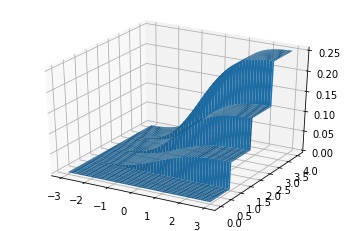

In [4]:
# plot mixture of continuous and categorical - CDF
x=np.linspace(-3,3,100)
y=np.linspace(0,4,100)
X, Y = np.meshgrid(x,y)
x_unif_samp = 0.5
x_date_samp = np.median(df['x_date'])
z = np.array([sd.kde.cdf([x,x_unif_samp,y,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

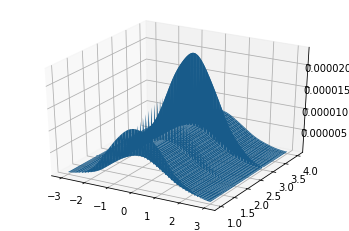

In [14]:
# plot mixture of continuous and categorical - PDF
x=np.linspace(-3,3,100)
y=np.linspace(1,4,100)
X, Y = np.meshgrid(x,y)
x_unif_samp = 0.5
x_date_samp = np.median(df['x_date'])
z = np.array([sd.kde.pdf([x,x_unif_samp,y,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

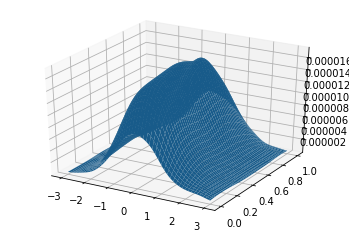

In [16]:
# plot continuous vars - PDF
x=np.linspace(-3,3,100)
y=np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)

x_categ_samp = 2
x_date_samp = np.median(df['x_date'])
z = np.array([sd.kde.pdf([x,y,x_categ_samp,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

In [5]:
# get synthetic data
df_samp = sd.get_sample(n=1000)

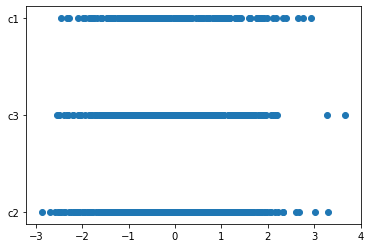

In [8]:
# plot sampled data - normal vs categorical
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_categ'])

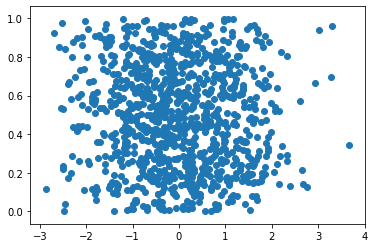

In [10]:
# plot sampled data - normal vs uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_unif'])